# Exploring Wikileaks' Aghanistan Casualities Dataset

Importing libraries to be used

In [1]:
import numpy as np
import pandas as pd

### Reading an inspecting the file

In [2]:
fl = "Wikileaks_Afghanistan_war_logs_analysis_-_TOTAL_CASUALTIES_ALL_CAUSES.csv"

In [3]:
db = pd.read_csv(fl, skiprows=[0, -1], thousands=",")

In [4]:
db.shape

(73, 7)

The dataframe has 73 rows but the original csv has just 72 rows. We need to inspect the dataframe to check where the error is.

In [5]:
db.head()

,Year,Month,Taliban,Civilians,Afghan forces,Nato (detailed in spreadsheet),Nato - official figures
0,2004.0,January,15.0,51,23.0,NaN,11.0
1,2004.0,February,NaN,7,4.0,5.0,2.0
2,2004.0,March,19.0,2,NaN,2.0,3.0
3,2004.0,April,5.0,3,19.0,NaN,3.0
4,2004.0,May,18.0,29,56.0,6.0,9.0


In [6]:
db.tail()

,Year,Month,Taliban,Civilians,Afghan forces,Nato (detailed in spreadsheet),Nato - official figures
68,2009.0,September,614.0,197,133.0,54.0,70.0
69,2009.0,October,462.0,107,86.0,76.0,74.0
70,2009.0,November,410.0,120,69.0,30.0,32.0
71,2009.0,December,287.0,87,65.0,33.0,35.0
72,NaN,24498,15507.0,4024,3820.0,1147.0,NaN


We see that the last row has NaN year and a strange Month value. This is where the error lies. We should drop the row.

In [7]:
db[db.Year.isna()]

,Year,Month,Taliban,Civilians,Afghan forces,Nato (detailed in spreadsheet),Nato - official figures
72,NaN,24498,15507.0,4024,3820.0,1147.0,NaN


In [8]:
db = db.dropna(axis=0, subset=['Year'])

In [9]:
db.shape

(72, 7)

Before proceeding with our analysis, we must ensure that our columns datatypes are correct.

In [10]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 0 to 71
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Year                            72 non-null     float64
 1   Month                           72 non-null     object 
 2   Taliban                         71 non-null     float64
 3   Civilians                       72 non-null     int64  
 4   Afghan forces                   70 non-null     float64
 5   Nato (detailed in spreadsheet)  66 non-null     float64
 6   Nato - official figures         72 non-null     float64
dtypes: float64(5), int64(1), object(1)
memory usage: 4.5+ KB


The year column is supposed to be an object (or at least an integer). Let us convert it.
The following line converts each year to a string and slices all of it except the trailing decimal point and zero.

***CAUTION!***

Running the below cell more than once will slice the year values beyond usefulness.

In [11]:
db['Year'] = db['Year'].astype('object').apply(lambda x: str(x)[:-2])

In [12]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 0 to 71
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Year                            72 non-null     object 
 1   Month                           72 non-null     object 
 2   Taliban                         71 non-null     float64
 3   Civilians                       72 non-null     int64  
 4   Afghan forces                   70 non-null     float64
 5   Nato (detailed in spreadsheet)  66 non-null     float64
 6   Nato - official figures         72 non-null     float64
dtypes: float64(4), int64(1), object(2)
memory usage: 4.5+ KB


We should confirm the year values before proceeding.

In [13]:
db.Year.unique()

array(['2004', '2005', '2006', '2007', '2008', '2009'], dtype=object)

The month column is in the object type. Apparently, this looks okay. However, the pandas object type can store all sorts of objects. Therefore, we must inspect it to confirm that it actually contains only the twelve calender months and the spellings of each month is consistent.

In [14]:
db.Month.unique(), db.Month.nunique()

(array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
        'August', 'September', 'October', 'November', 'December'],
       dtype=object),
 12)

Very good. We the spellings are all consistent and the total number of unique months is twelve.

# Data Exploration
After cleaning our data, we are ready to start answering questions on our data.

### First Question
Question: Obtain the minimum number of civilian casualties (in what month was that?)

In [15]:
db['Civilians'].min()

2

In [16]:
db.loc[db.Civilians == db['Civilians'].min()]

,Year,Month,Taliban,Civilians,Afghan forces,Nato (detailed in spreadsheet),Nato - official figures
2,2004,March,19.0,2,NaN,2.0,3.0


Answer: The month with the lowest civilian casuality is March, 2004. Two civilian lives were lost.

### Second Question
How many NATO casualties were registered in August 2008?

In [17]:
db.query("(Year == '2008')&(Month == 'August')")

,Year,Month,Taliban,Civilians,Afghan forces,Nato (detailed in spreadsheet),Nato - official figures
55,2008,August,326.0,46,61.0,46.0,46.0


Answer: 46 Nato casualties were registered in August, 2008.

### Third Question
What is the month with the most total number of casualties?

In [18]:
db['Total']= db.iloc[:, 2:7].sum(axis=1)

In [19]:
db.query("Total == Total.max()")

,Year,Month,Taliban,Civilians,Afghan forces,Nato (detailed in spreadsheet),Nato - official figures,Total
32,2006,September,945.0,172,97.0,19.0,38.0,1271.0


Answer: September, 2006 had the highest number of casualities.

### Fourth and Last Question
Can you make a plot of the distribution of casualties over time?

In [20]:
from datetime import datetime

In [21]:
month_year = db['Month'] + ' ' + db['Year']

In [22]:
db['dt'] = month_year.apply(lambda x: datetime.strptime(x,'%B %Y'))

In [23]:
db_dt = db.set_index(keys='dt', drop=True)

In [24]:
db_dt.columns

Index(['Year', 'Month', 'Taliban', 'Civilians', 'Afghan forces',
       'Nato (detailed in spreadsheet)', 'Nato - official figures', 'Total'],
      dtype='object')

In [25]:
db_dt.drop(columns=['Year', 'Month'], inplace=True)

In [26]:
db_dt

,Taliban,Civilians,Afghan forces,Nato (detailed in spreadsheet),Nato - official figures,Total
dt,,,,,,
2004-01-01,15.0,51,23.0,NaN,11.0,100.0
2004-02-01,NaN,7,4.0,5.0,2.0,18.0
2004-03-01,19.0,2,NaN,2.0,3.0,26.0
2004-04-01,5.0,3,19.0,NaN,3.0,30.0
2004-05-01,18.0,29,56.0,6.0,9.0,118.0
...,...,...,...,...,...,...
2009-08-01,445.0,206,190.0,64.0,77.0,982.0
2009-09-01,614.0,197,133.0,54.0,70.0,1068.0
2009-10-01,462.0,107,86.0,76.0,74.0,805.0


In [27]:
%matplotlib inline

import seaborn as sns

sns.set(rc={'figure.figsize':(15,10)})

Text(0, 0.5, 'Number of casualities')

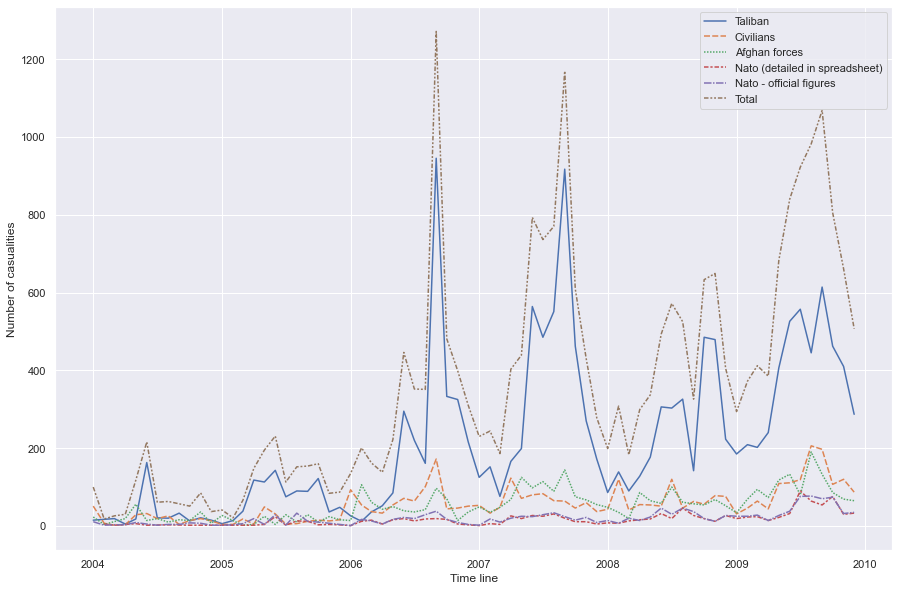

In [28]:
p = sns.lineplot(data=db_dt);
p.set_xlabel('Time line')
p.set_ylabel('Number of casualities')

# The End